In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from facenet_pytorch import InceptionResnetV1
import torch
import torch.nn as nn
import torch.optim as optim
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from PIL import Image
import pandas as pd
import shutil
import random
from deepface import DeepFace
from keras.models import Model
import cv2

dividi in altro modo il dataset in training etc enedno conto dei labels uguali .

In [3]:
# Set the path to your balanced dataset
dataset_path = "/Users/stellafazioli/Documents/balanced_dataset/Casia"

image_filenames = os.listdir(dataset_path)

# Extract the labels from the image filenames based on the first part before the underscore
labels = [filename.split("_")[0] for filename in image_filenames]
count=[]
for name in labels:
    if name not in count:
        count.append(name)
        
train_dir="/Users/stellafazioli/Documents/balanced_dataset/Casia/train"

val_dir="/Users/stellafazioli/Documents/balanced_dataset/Casia/validation"


In [4]:
train_folder = "/Users/stellafazioli/Documents/balanced_dataset/Casia/train"
validation_folder ="/Users/stellafazioli/Documents/balanced_dataset/Casia/validation"
train_folder = "/Users/stellafazioli/Documents/balanced_dataset/Casia/train"
validation_folder ="/Users/stellafazioli/Documents/balanced_dataset/Casia/validation"
train_classes = os.listdir(train_folder)


In [7]:
print(os.listdir(train_dir))

['0001082_014.jpg', '0001103_022.jpg', '0000302_020.jpg', '0004786_041.jpg', '0000816_004.jpg', '0000997_032.jpg', '0005142_078.jpg', '0001083_207.jpg', '0004770_390.jpg', '0000535_197.jpg', '0001642_061.jpg', '0005232_001.jpg', '0001760_034.jpg', '0005278_040.jpg', '0001608_020.jpg', '0001467_083.jpg', '0001858_009.jpg', '0005311_247.jpg', '0005392_288.jpg', '0005188_135.jpg', '0005009_103.jpg', '0000595_037.jpg', '0000588_014.jpg', '0001367_024.jpg', '0002006_081.jpg', '0000982_177.jpg', '0000166_026.jpg', '0000192_027.jpg', '0000397_069.jpg', '0000295_090.jpg', '0005253_049.jpg', '0005123_030.jpg', '0001504_032.jpg', '0005219_008.jpg', '0001669_068.jpg', '0010736_247.jpg', '0001519_011.jpg', '0000619_129.jpg', '0000159_379.jpg', '0001774_362.jpg', '0001029_111.jpg', '0002127_117.jpg', '0001347_088.jpg', '0005299_104.jpg', '0004909_060.jpg', '0000147_299.jpg', '0000670_007.jpg', '0000705_030.jpg', '0005305_111.jpg', '0000335_219.jpg', '0000293_002.jpg', '0000189_096.jpg', '0001652_07

In [30]:
def preprocess_image(image):
    # Perform face detection and any other desired preprocessing steps
    # You can use cv2 or a face detection model like dlib or MTCNN
    image = cv2.convertScaleAbs(image)
    # Example using cv2 for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        face_image = image[y:y+h, x:x+w].astype('float32')
        face_image /= 255.0 
        
        target_size = (160, 160)
        face_image = cv2.resize(face_image, target_size)
        
        return face_image
    else:
        # Return the original image if no face is detected
        return image.astype('float32') / 255.0

In [31]:


# Set the image size for the pretrained model
image_size = (160, 160)

# Set the number of classes (number of individuals in the dataset)
num_classes = 1252

# Set the batch size and number of epochs for training
batch_size = 32
num_epochs = 10

# Create an ImageDataGenerator for data augmentation and preprocessing
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)



# Load and preprocess images using the generator
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = data_generator.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)





Found 65033 images belonging to 1252 classes.
Found 15651 images belonging to 1252 classes.


In [14]:
# Load the pretrained VGGFace model (include_top=False to exclude the classifier layers)
base_model = DeepFace.build_model("Facenet512")

#for layer in base_model.layers[:-3]:
#    layer.trainable = False
# Build the top layers of the model for classification
model = Sequential()
model.add(base_model)
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))



# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




# Train the model


In [10]:
from keras.callbacks import ReduceLROnPlateau

# Define the callback with desired parameters
lr_callback = ReduceLROnPlateau(factor=0.1, patience=5)


history=model.fit(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[lr_callback],
    verbose=1
)
#

Epoch 1/10
2033/2033 [==============================] - 1618s 793ms/step - loss: 1.9200 - accuracy: 0.6702 - val_loss: 1.2397 - val_accuracy: 0.7776 - lr: 0.0010
Epoch 2/10
2033/2033 [==============================] - 1603s 788ms/step - loss: 1.1208 - accuracy: 0.7831 - val_loss: 1.1933 - val_accuracy: 0.7876 - lr: 0.0010
Epoch 3/10
2033/2033 [==============================] - 1593s 783ms/step - loss: 0.9950 - accuracy: 0.8041 - val_loss: 1.2108 - val_accuracy: 0.7957 - lr: 0.0010
Epoch 4/10
2033/2033 [==============================] - 1455s 716ms/step - loss: 0.9025 - accuracy: 0.8180 - val_loss: 1.2302 - val_accuracy: 0.8042 - lr: 0.0010
Epoch 5/10
2033/2033 [==============================] - 1476s 726ms/step - loss: 0.8451 - accuracy: 0.8265 - val_loss: 1.2682 - val_accuracy: 0.8027 - lr: 0.0010
Epoch 6/10
2033/2033 [==============================] - 1575s 774ms/step - loss: 0.7879 - accuracy: 0.8363 - val_loss: 1.3536 - val_accuracy: 0.7991 - lr: 0.0010
Epoch 7/10
2033/2033 [======

In [11]:
from keras.models import save_model

#loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))
#print('Test loss:', loss)
#print('Test accuracy:', accuracy)


save_model(model, 'model_architecture.h5')

In [12]:

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(val_generator, verbose=1)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

490/490 [==============================] - 304s 620ms/step - loss: 1.2252 - accuracy: 0.8402
Test Loss: 1.225162386894226
Test Accuracy: 0.8402019143104553


In [29]:
#from keras.models import load_model
#
## Specify the path to the saved model
#model_path = 'model_architecture.h5'
#
## Load the model
#loaded_model = load_model(model_path)

In [32]:
# Assuming you have a trained model 'model' and validation data 'val_images' and 'val_labels'

# Make predictions on the validation data
predicted_probs = model.predict(val_generator)

# Assuming predicted_probs is a 2D array, extract the probabilities for the positive class
positive_probs = predicted_probs[:, 1]

# Convert true labels to binary format (0 or 1)
true_labels = val_generator.labels



490/490 [==============================] - 691s 1s/step


In [43]:
print(num_classes)

1248


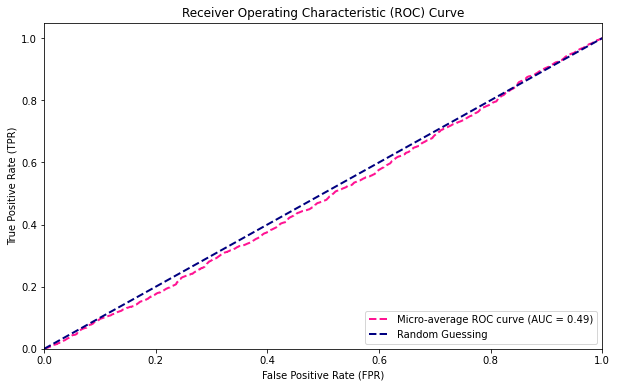

Optimal Threshold: 0.00076870254


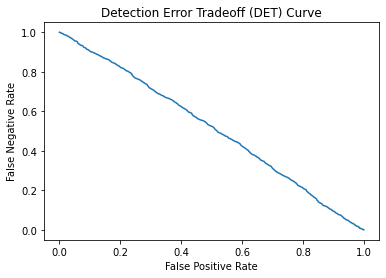

Class 0: Threshold = [1.0007066e+00 7.0654252e-04 7.0480700e-04 ... 7.0106547e-04 7.0106075e-04
 6.9871393e-04]
Class 1: Threshold = [1.0005939e+00 5.9384410e-04 5.9219106e-04 ... 5.8773934e-04 5.8770628e-04
 5.8569683e-04]
Class 2: Threshold = [1.0007864e+00 7.8638026e-04 7.8391557e-04 ... 7.7782816e-04 7.7782746e-04
 7.7396457e-04]
Class 3: Threshold = [1.0008347e+00 8.3470938e-04 8.3190005e-04 ... 8.2640239e-04 8.2640117e-04
 8.2475174e-04]
Class 4: Threshold = [1.0011929  0.00119287 0.00119109 ... 0.00118391 0.0011839  0.00118213]
Class 5: Threshold = [1.0005566e+00 5.5654784e-04 5.5410579e-04 ... 5.5052707e-04 5.5051938e-04
 5.4914784e-04]
Class 6: Threshold = [1.0005869e+00 5.8681326e-04 5.8565190e-04 ... 5.7996571e-04 5.7996553e-04
 5.7531265e-04]
Class 7: Threshold = [1.0011827  0.00118271 0.00117758 ... 0.00116962 0.00116962 0.00116696]
Class 8: Threshold = [1.0007288e+00 7.2882633e-04 7.2475517e-04 ... 7.2016212e-04 7.2016200e-04
 7.1729074e-04]
Class 9: Threshold = [1.000661

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score,auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

num_classes = len(np.unique(true_labels))+4
binary_labels = label_binarize(true_labels, classes=np.arange(num_classes))

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
thresholds=dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(binary_labels[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-averaged ROC curve and AUC
fpr["micro"], tpr["micro"], thresholds['micro'] = roc_curve(binary_labels.ravel(), predicted_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 6))
#colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
#for i, color in zip(range(num_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (class {0}) (AUC = {1:.2f})'.format(i, roc_auc[i]))

# Plot micro-averaged ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2, linestyle='--', label='Micro-average ROC curve (AUC = {0:.2f})'.format(roc_auc["micro"]))

# Plot random guessing line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Find the optimal threshold for the ROC curve
# Convert dictionaries to arrays
# Calculate F1 score for each threshold
f1_scores = 2 * (tpr['micro'] * (1 - fpr['micro'])) / (tpr['micro'] + (1 - fpr['micro']))

# Find the index of the threshold that maximizes the F1 score
optimal_threshold_index = np.argmax(f1_scores)

# Get the optimal threshold value
optimal_threshold = thresholds['micro'][optimal_threshold_index]

# Print the optimal threshold
print("Optimal Threshold:", optimal_threshold)


# Compute the False Negative Rate (FNR)
fnr = 1 - tpr['micro']

# Compute the Detection Error Tradeoff (DET) curve
plt.plot(fpr['micro'], fnr)
plt.xlabel('False Positive Rate')
plt.ylabel('False Negative Rate')
plt.title('Detection Error Tradeoff (DET) Curve')
plt.show()



# Print the thresholds between FRR and FAR for each class
for i in range(num_classes):
    print(f"Class {i}: Threshold = {thresholds[i]}")

In [34]:
# Plot FNR vs. FPR curves
plt.plot(fpr['micro'], fnr['micro'])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('False Negative Rate (FNR)')
plt.title('FNR vs. FPR')

# Find the threshold at the crossing point
crossing_idx = np.argmin(np.abs(np.array(fpr) - np.array(fnr)))
crossing_threshold = thresholds[crossing_idx]

# Plot the crossing point
plt.plot(fpr[crossing_idx], fnr[crossing_idx], 'ro')
plt.annotate(f'Threshold = {crossing_threshold:.2f}', xy=(fpr[crossing_idx], fnr[crossing_idx]), xytext=(0.2, 0),
             arrowprops=dict(arrowstyle='->'))
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [18]:
#plot FAR and FRR

import numpy as np
import matplotlib.pyplot as plt

# Assuming you have binary_labels and predicted_probs as the outputs of your model

# Compute FAR and FRR for different thresholds
thresholds = np.linspace(0, 1, 100)  # Threshold values
far = []
frr = []
for threshold in thresholds:
    # Apply threshold to predicted probabilities
    predictions = predicted_probs >= threshold

    # Compute FAR and FRR
    false_acceptances = np.sum(predictions[~binary_labels]) / np.sum(~binary_labels)
    false_rejections = np.sum(~predictions[binary_labels]) / np.sum(binary_labels)

    total_negatives = np.sum(np.logical_not(binary_labels))
    total_positives = np.sum(binary_labels)

    far.append(false_acceptances / total_negatives)
    frr.append(false_rejections / total_positives)

# Plot FAR vs. FRR curves
plt.plot(thresholds, far, label='FAR')
plt.plot(thresholds, frr, label='FRR')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('FAR vs. FRR')
plt.legend()

# Find the threshold at the crossing point
crossing_idx = np.argmin(np.abs(np.array(far) - np.array(frr)))
crossing_threshold = thresholds[crossing_idx]

# Plot the crossing point
plt.plot(crossing_threshold, far[crossing_idx], 'ro')
plt.plot(crossing_threshold, frr[crossing_idx], 'ro')
plt.annotate(f'Threshold = {crossing_threshold:.2f}', xy=(crossing_threshold, far[crossing_idx]), xytext=(0, 0.2),
             arrowprops=dict(arrowstyle='->'))

plt.show()


KeyboardInterrupt: 

0.000772111691979014


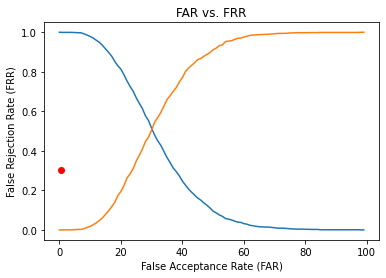

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have binary_labels and predicted_probs as the outputs of your model

# Compute FAR and FRR for different thresholds
#thresholds = np.linspace(0, 1, 100)  # Threshold values
min_prob = np.min(predicted_probs)
max_prob = np.max(predicted_probs)

# Define the range of thresholds
thresholds = np.linspace(min_prob, max_prob, 100)

far = []
frr = []
for threshold in thresholds:
    # Apply threshold to predicted probabilities
    predictions = predicted_probs >= threshold

    # Compute FAR and FRR
    false_acceptances = np.sum(predictions[binary_labels == 0]) / np.sum(binary_labels == 0)
    false_rejections = np.sum(predictions[binary_labels == 1]) / np.sum(binary_labels == 1)

    

    far.append(false_acceptances)
    frr.append(1-false_rejections)

far = np.array(far)
frr = np.array(frr)


# Plot FAR vs. FRR curves
plt.plot(far, label='FAR')
plt.plot(frr, label='FRR')
plt.xlabel('False Acceptance Rate (FAR)')
plt.ylabel('False Rejection Rate (FRR)')
plt.title('FAR vs. FRR')

# Find the threshold at the crossing point

# Find the threshold at the crossing point
#distances = np.abs(far - frr)
#crossing_idx = np.argmin(distances)
#crossing_far = far[crossing_idx]
#crossing_frr = frr[crossing_idx]
#crossing_threshold = thresholds[crossing_idx]

def find_crossing_point(x, curve1, curve2):
    # Find the index where the curves cross
    crossing_idx = np.argwhere(np.diff(np.sign(curve1 - curve2))).flatten()[0]

    # Get the x and y coordinates of the crossing point
    x_crossing = x[crossing_idx]
    y_crossing_curve1 = curve1[crossing_idx]
    y_crossing_curve2 = curve2[crossing_idx]

    return x_crossing, y_crossing_curve1, y_crossing_curve2

# Assuming you have two curves represented as NumPy arrays: far and frr
# Replace far and frr with your actual arrays

# Assuming you have x-coordinates for the curves
x = np.linspace(0, 1, len(far))

# Find the crossing point
x_crossing, y_crossing_far, y_crossing_frr = find_crossing_point(x, far, frr)


print(crossing_threshold)
# Plot the crossing point
plt.plot(x_crossing, y_crossing_frr, 'ro')
#plt.annotate(f'Threshold = {crossing_threshold:.2f}', xy=(far[crossing_idx], frr[crossing_idx]), xytext=(0.2, 0),
#             arrowprops=dict(arrowstyle='->'))

plt.show()


In [ ]:
# Train the model


#for epoch in range(num_epochs):
#    print(f"Epoch {epoch+1}/{num_epochs}")
#    history = model.fit(
#        train_images,
#        train_labels,
#        batch_size=batch_size,
#        epochs=1,
#        validation_data=(val_images, val_labels)
#    )
#    print("Train loss:", history.history['loss'][0])
#    print("Train accuracy:", history.history['accuracy'][0])
#    print("Validation loss:", history.history['val_loss'][0])
#    print("Validation accuracy:", history.history['val_accuracy'][0])




## Create generators for training and validation data
#train_generator = data_generator.flow_from_directory(
#    train_dir,
#    target_size=image_size,
#    batch_size=batch_size,
#    class_mode='categorical'
#)
#
#val_generator = data_generator.flow_from_directory(
#    val_dir,
#    target_size=image_size,
#    batch_size=batch_size,
#    class_mode='categorical'
#)
#
## Train the model
#model.fit(
#    train_generator,
#    epochs=num_epochs,
#    validation_data=val_generator
#)
#